In [320]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

from fbprophet import Prophet

import warnings
warnings.filterwarnings("ignore")

In [4]:
from fbprophet import Prophet, diagnostics
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric, add_changepoints_to_plot, plot_plotly


In [323]:
time = pd.read_csv('https://raw.githubusercontent.com/RileyWClarke/MLTSA_COVID19/master/Time.csv')
time.head()

,date,time,test,negative,confirmed,released,deceased
0,2020-01-20,16,1,0,1,0,0
1,2020-01-21,16,1,0,1,0,0
2,2020-01-22,16,4,3,1,0,0
3,2020-01-23,16,22,21,1,0,0
4,2020-01-24,16,27,25,2,0,0


In [324]:
time['date'] = pd.to_datetime(time['date'], format='%Y-%m-%d')

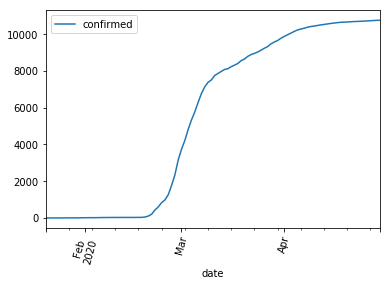

In [325]:
pd.plotting.register_matplotlib_converters()
time.plot(x='date',y='confirmed',rot = 75);

In [326]:
confirmed_data=time.reset_index().rename(columns={'date':'ds','confirmed':'y'})
deaths = time.reset_index().rename(columns={'date':'ds','deceased':'y'})
tests = time.reset_index().rename(columns={'date':'ds','test':'y'})
recovered = time.reset_index().rename(columns={'date':'ds','released':'y'})

In [327]:
confirmed_data.shape

(102, 8)

### Daily increase

In [328]:
def daily(data):
    dailyIncrease = [0]
    for i in range(data.y.size-1):
        dailyIncrease.append(data.y[i+1]- data.y[i])
    return np.array(dailyIncrease)

In [329]:
confirmed_data['dailyIncrease'] = daily(confirmed_data)
deaths['dailyIncrease'] = daily(deaths)
tests['dailyIncrease'] = daily(tests)
recovered['dailyIncrease'] = daily(recovered)

Text(0.5, 1.0, 'Deaths daily increase')

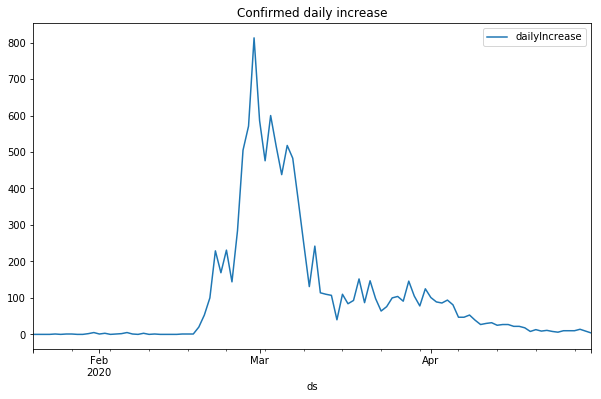

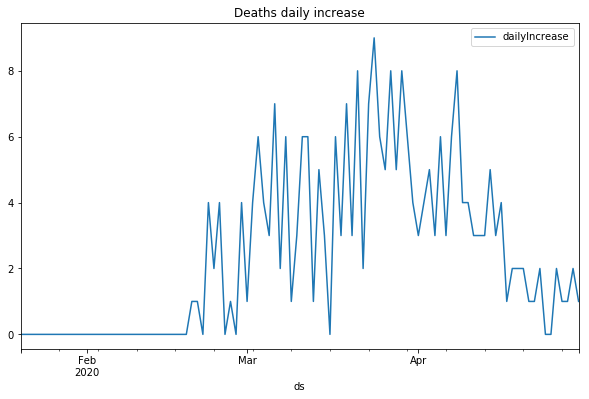

In [330]:
fig,ax=plt.subplots(figsize=(10,6))
confirmed_data.plot(x='ds',y='dailyIncrease',ax=ax)
ax.set_title('Confirmed daily increase')

fig,ax=plt.subplots(figsize=(10,6))
deaths.plot(x='ds',y='dailyIncrease',ax=ax)
ax.set_title('Deaths daily increase')


Text(0.5, 1.0, 'Cumulative deaths')

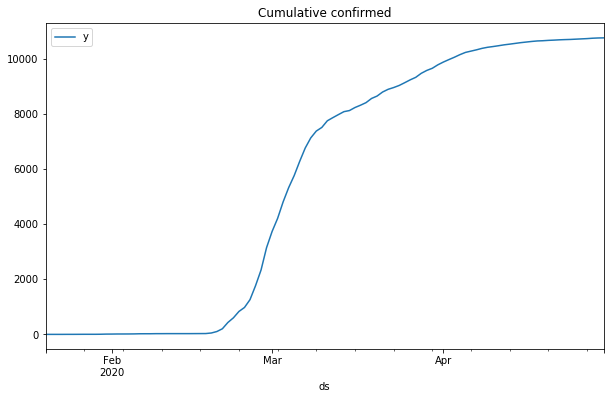

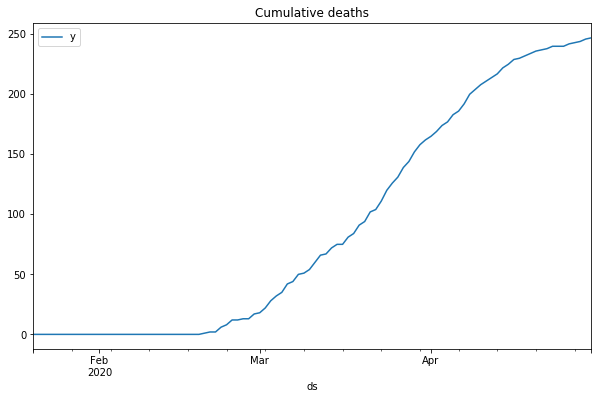

In [74]:
fig,ax=plt.subplots(figsize=(10,6))
confirmed_data.plot(x='ds',y='y',ax=ax)
ax.set_title('Cumulative confirmed')

fig,ax=plt.subplots(figsize=(10,6))
deaths.plot(x='ds',y='y',ax=ax)
ax.set_title('Cumulative deaths')

In [126]:
def mape(y, ytrue): #mean absolute percentage error
    return np.mean(np.abs((ytrue-y)/ytrue))

# 1. Using linear growth with only weekly seasonality and define the changepoints.

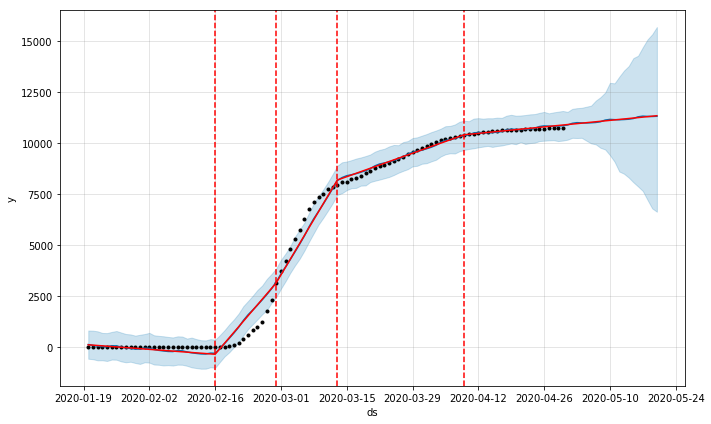

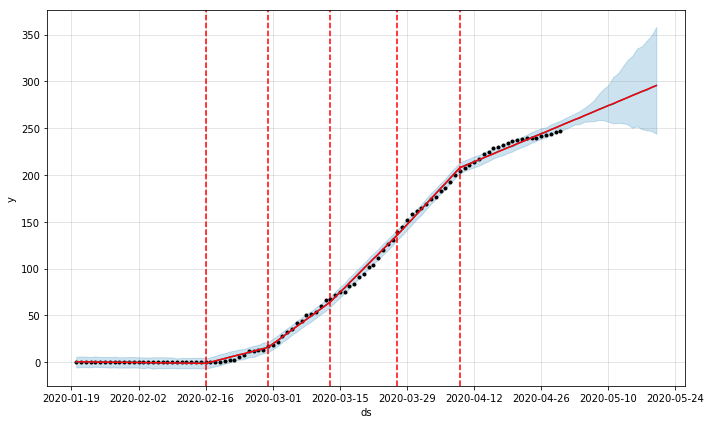

In [63]:
simp = Prophet(growth='linear',interval_width=0.95,n_changepoints=6,
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
    changepoint_prior_scale=0.1) #changepoints = ['2020-02-21', '2020-02-25','2020-03-08'],
    
#confirmed_data['cap'] = 10000
simp.fit(confirmed_data)
future = simp.make_future_dataframe(periods=20)
forecast = simp.predict(future)
fig3 = simp.plot(forecast)

a3 = add_changepoints_to_plot(fig3.gca(), simp, forecast)


simp_deaths = Prophet(growth='linear',interval_width=0.95,n_changepoints=6,
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
    changepoint_prior_scale=0.1) #changepoints = ['2020-02-21', '2020-02-25','2020-03-08'],
    
#confirmed_data['cap'] = 10000
simp_deaths.fit(deaths)
future = simp_deaths.make_future_dataframe(periods=20)
forecast = simp_deaths.predict(future)
fig3 = simp_deaths.plot(forecast)

a3 = add_changepoints_to_plot(fig3.gca(), simp_deaths, forecast)

In [48]:
cvresult_simp = cross_validation(simp, horizon = '10 days')

INFO:fbprophet:Making 11 forecasts with cutoffs between 2020-02-20 00:00:00 and 2020-04-10 00:00:00


In [49]:
cvresult_simp.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-02-21,45.913504,27.016424,65.657307,204,2020-02-20
1,2020-02-22,46.164524,24.870101,68.113678,433,2020-02-20
2,2020-02-23,48.165531,27.588850,68.321485,602,2020-02-20
3,2020-02-24,50.996099,31.224813,72.527035,833,2020-02-20
4,2020-02-25,51.597190,30.189537,73.528173,977,2020-02-20


In [50]:
print('Mean absolute percentage error is  {:.4f}.'.format(mape(cvresult_simp.yhat, 
                                                           cvresult_simp.y)))

Mean absolute percentage error is  0.2600.


In [51]:
performance_metrics(cvresult_simp)

,horizon,mse,rmse,mae,mape,coverage
0,1 days,2.899707e+05,538.489305,391.286961,0.185158,0.454545
1,2 days,5.810189e+05,762.245929,563.261997,0.213885,0.454545
2,3 days,9.831964e+05,991.562584,734.675763,0.230668,0.454545
3,4 days,1.609087e+06,1268.497790,930.004390,0.245361,0.454545
4,5 days,2.203401e+06,1484.385599,1095.566035,0.256454,0.454545
5,6 days,2.872625e+06,1694.882077,1276.680598,0.268551,0.454545
6,7 days,3.827721e+06,1956.456136,1477.997764,0.280087,0.545455
7,8 days,5.138011e+06,2266.718105,1711.624308,0.296635,0.545455
8,9 days,6.515654e+06,2552.577926,1918.397223,0.307022,0.545455
9,10 days,8.010257e+06,2830.239688,2112.717960,0.316132,0.545455


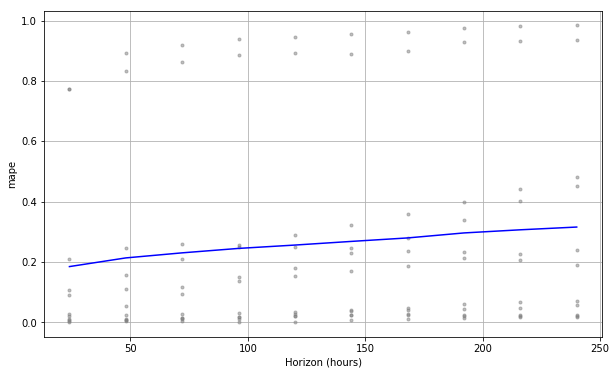

In [52]:
plot_cross_validation_metric(cvresult_simp, metric='mape');

# 3. Logistic growth with only weekly seasonality.

Text(0.5, 1.0, 'South Korea')

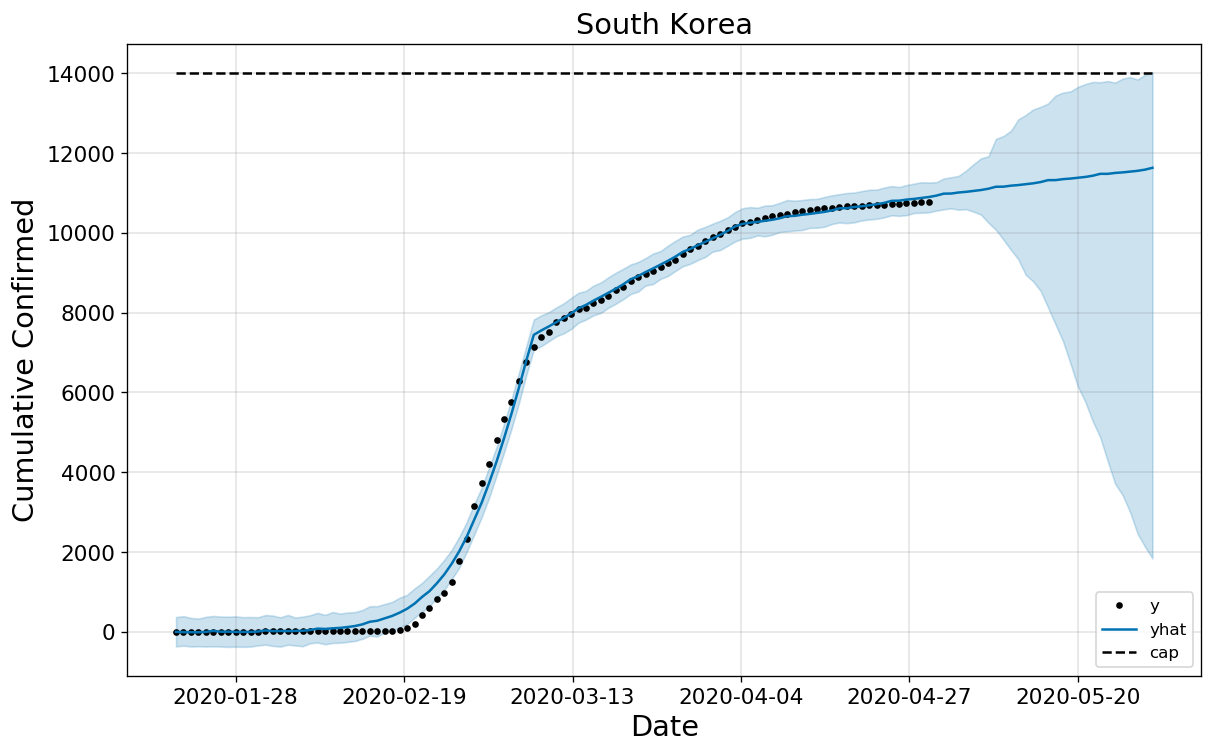

In [286]:
#define changepoints
simlog2 = Prophet(growth='logistic',interval_width=0.95,n_changepoints=4,
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
    changepoints = ['2020-02-27','2020-03-08','2020-04-05'],  #'2020-02-21', '2020-02-27',
    changepoint_prior_scale=0.25)

confirmed_train = confirmed_data[:]
confirmed_train['cap'] = 14000
simlog2.fit(confirmed_train)
future = simlog2.make_future_dataframe(periods=30)
future['cap'] = 14000
forecast = simlog2.predict(future)

fig5, ax = plt.subplots(figsize=(10,6),dpi=120)
simlog2.plot(forecast,ax=ax)
ax.set_xlabel('Date',fontsize='xx-large')
ax.set_ylabel('Cumulative Confirmed',fontsize='xx-large')

ax.set_xticks(pd.date_range('2020-01-28','2020-05-20', periods=6))
ax.tick_params(axis='both', which='major', labelsize=13)
#
#ax.plot(confirmed_data[-10:].ds,confirmed_data[-10:].y,'.',c='r',label='Actual curve')

#a5 = add_changepoints_to_plot(fig5.gca(), simlog2, forecast,trend=False)
ax.legend()
ax.set_title('South Korea',fontsize='xx-large')
#define changepoints


In [302]:
 simlog2_deaths.changepoints.date[0]

datetime.date(2020, 2, 27)

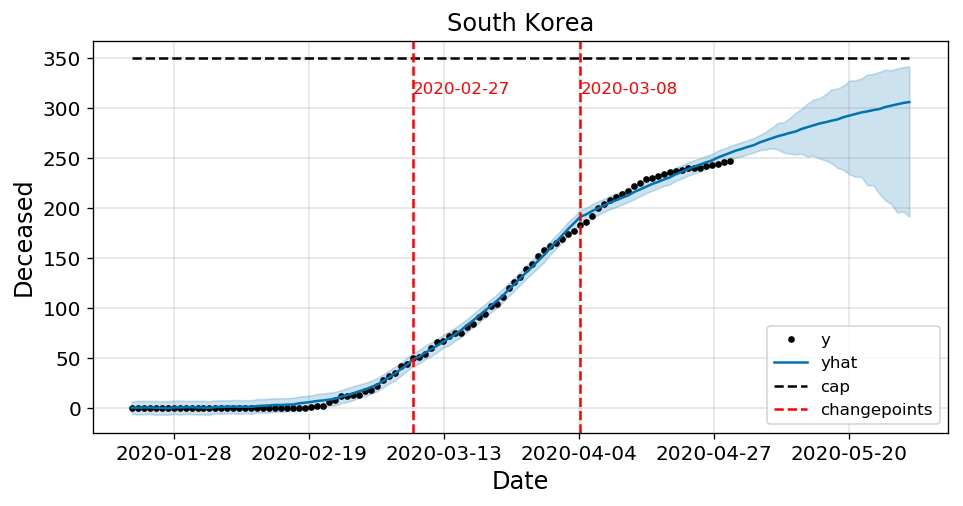

In [342]:

simlog2_deaths = Prophet(growth='logistic',interval_width=0.95,n_changepoints=2,
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
    changepoints =  ['2020-02-27',' 2020-03-08',' 2020-04-05'],          #['2020-02-27',' 2020-03-08',' 2020-04-05'],
    changepoint_prior_scale=0.25)

deaths_train = deaths[1:]
deaths_train['cap'] = 350
simlog2_deaths.fit(deaths_train)
future_deaths = simlog2_deaths.make_future_dataframe(periods=30)
future_deaths['cap'] = 350
forecast_deaths = simlog2_deaths.predict(future_deaths)

fig5, ax = plt.subplots(figsize=(8,4),dpi=120)
simlog2_deaths.plot(forecast_deaths,ax=ax)
ax.set_xlabel('Date',fontsize='x-large')
ax.set_ylabel('Deceased',fontsize='x-large')
ax.tick_params(axis='both', which='major', labelsize=12)

#
#ax.plot(deaths[-10:].ds,deaths[-10:].y,'.',c='r',label='Actual curve')

a5 = add_changepoints_to_plot(fig5.gca(), simlog2_deaths, forecast_deaths,trend=False)

a5[0].set_label('changepoints')
ax.text(x= simlog2_deaths.changepoints.date[1], y =deaths_train['cap'].values[0]-0.1*deaths_train['cap'].values[0] ,s =simlog2_deaths.changepoints.date[0],color='red')#,horizontalalignment='center'
ax.text(x= simlog2_deaths.changepoints.date[2], y = deaths_train['cap'].values[0]-0.1*deaths_train['cap'].values[0],s =simlog2_deaths.changepoints.date[1],color='red')

ax.legend()
ax.set_title('South Korea',fontsize='x-large')
#ax.set_xticks(['2020-01-28','2020-02-20','2020-03-12','2020-04-05','2020-04-25','2020-05-15',])
ax.set_xticks(pd.date_range('2020-01-28','2020-05-20', periods=6))


# cvresult_simlog = cross_validation(simlog2_deaths, horizon = '10 days')
# print(performance_metrics(cvresult_simlog))
# fig6, ax2 = plt.subplots(figsize=(10,3),dpi=120)
# plot_cross_validation_metric(cvresult_simlog, metric='mape',ax = ax2);
# ax2.set_title('South Korea',fontsize='xx-large')
# ax2.tick_params(axis='both', which='major', labelsize=15)
# ax2.set_xlabel('Horizon (Hours)',fontsize='xx-large')
# ax2.set_ylabel('MAPE',fontsize='xx-large')
# ax2.set_ylim(0,5)

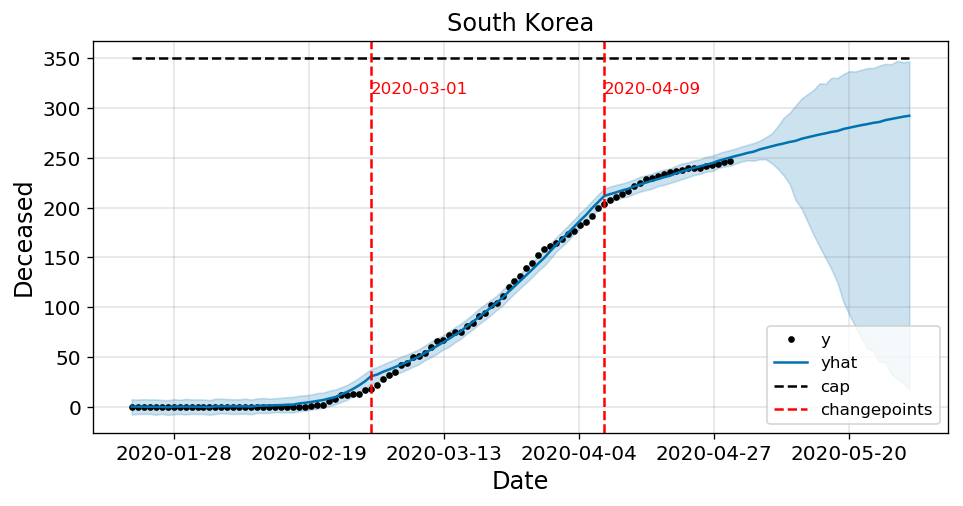

In [337]:
# free the changepoints
simlog2_deaths = Prophet(growth='logistic',interval_width=0.95,n_changepoints=2,
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
    #changepoints = ['2020-04-09'],
    changepoint_prior_scale=1)

deaths_train = deaths[1:]
deaths_train['cap'] = 350
simlog2_deaths.fit(deaths_train)
future_deaths = simlog2_deaths.make_future_dataframe(periods=30)
future_deaths['cap'] = 350
forecast_deaths = simlog2_deaths.predict(future_deaths)

fig5, ax = plt.subplots(figsize=(8,4),dpi=120)
simlog2_deaths.plot(forecast_deaths,ax=ax)
ax.set_xlabel('Date',fontsize='x-large')
ax.set_ylabel('Deceased',fontsize='x-large')
ax.tick_params(axis='both', which='major', labelsize=12)

#
#ax.plot(deaths[-10:].ds,deaths[-10:].y,'.',c='r',label='Actual curve')

a5 = add_changepoints_to_plot(fig5.gca(), simlog2_deaths, forecast_deaths,trend=False)
a5[0].set_label('changepoints')
ax.text(x= simlog2_deaths.changepoints.iloc[0], y =deaths_train['cap'].values[0]-0.1*deaths_train['cap'].values[0] ,s =simlog2_deaths.changepoints.iloc[0].date(),color='red')#,horizontalalignment='center'
ax.text(x= simlog2_deaths.changepoints.iloc[1], y = deaths_train['cap'].values[0]-0.1*deaths_train['cap'].values[0],s =simlog2_deaths.changepoints.iloc[1].date(),color='red')

ax.legend()
ax.set_title('South Korea',fontsize='x-large')
#ax.set_xticks(['2020-01-28','2020-02-20','2020-03-12','2020-04-05','2020-04-25','2020-05-15',])
ax.set_xticks(pd.date_range('2020-01-28','2020-05-20', periods=6))


# cvresult_simlog = cross_validation(simlog2_deaths, horizon = '10 days')
# print(performance_metrics(cvresult_simlog))
# fig6, ax2 = plt.subplots(figsize=(10,3),dpi=120)
# plot_cross_validation_metric(cvresult_simlog, metric='mape',ax = ax2);
# ax2.set_title('South Korea',fontsize='xx-large')
# ax2.tick_params(axis='both', which='major', labelsize=15)
# ax2.set_xlabel('Horizon (Hours)',fontsize='xx-large')
# ax2.set_ylabel('MAPE',fontsize='xx-large')
# ax2.set_ylim(0,5)

In [295]:
simlog2_deaths.changepoints

40   2020-03-01
79   2020-04-09
Name: ds, dtype: datetime64[ns]

In [135]:
simlog2_deaths.changepoints

80   2020-04-09
Name: ds, dtype: datetime64[ns]

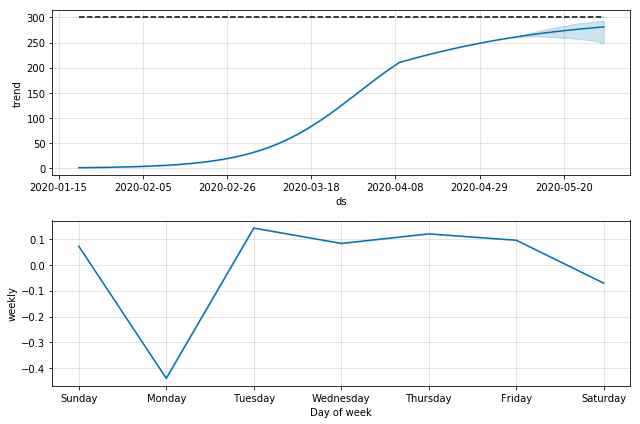

In [136]:
simlog2_deaths.plot_components(forecast_deaths);

In [140]:
cvresult_simlog2 = cross_validation(simlog2_deaths, horizon = '10 days')

print('Mean absolute percentage error is  {:.4f}.'.format(mape(cvresult_simlog2.yhat, 
                                                           cvresult_simlog2.y)))
performance_metrics(cvresult_simlog2)

INFO:fbprophet:Making 13 forecasts with cutoffs between 2020-02-20 00:00:00 and 2020-04-20 00:00:00


Mean absolute percentage error is  0.8915.


,horizon,mse,rmse,mae,mape,coverage
0,1 days,16.801334,4.098943,3.333959,0.089242,0.461538
1,2 days,47.776669,6.912067,5.604423,0.230079,0.461538
2,3 days,128.461199,11.334073,8.068422,0.301065,0.384615
3,4 days,297.582905,17.250591,12.201276,0.439708,0.307692
4,5 days,678.542045,26.048840,16.614110,0.632832,0.461538
5,6 days,1487.571204,38.569045,23.978727,0.955875,0.461538
6,7 days,3022.389257,54.976261,32.385073,1.274048,0.461538
7,8 days,5309.127451,72.863760,41.153126,1.674265,0.461538
8,9 days,7551.442463,86.899036,48.585829,1.646023,0.461538
9,10 days,9182.271253,95.824168,53.807133,1.671837,0.461538


In [141]:
cvresult_simlog2.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-02-21,1.824947,1.687969,1.967498,2,2020-02-20
1,2020-02-22,4.145356,4.008935,4.283105,2,2020-02-20
2,2020-02-23,9.344717,9.212187,9.478785,6,2020-02-20
3,2020-02-24,20.630471,20.491189,20.773360,8,2020-02-20
4,2020-02-25,43.521546,43.381903,43.648649,12,2020-02-20


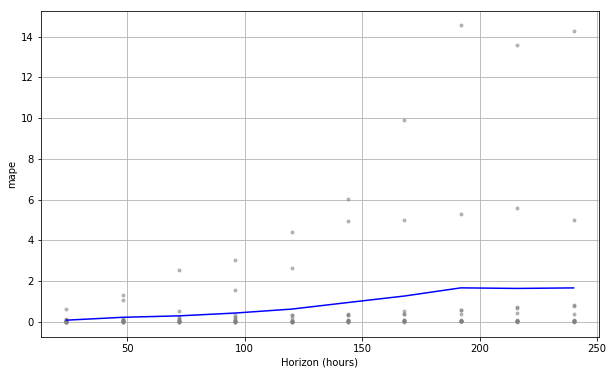

In [142]:
plot_cross_validation_metric(cvresult_simlog2, metric='mape');

### Add additional regressor

In [ ]:
#skip this cell.
simlog2_deaths = Prophet(growth='logistic',interval_width=0.95,n_changepoints=1,
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
    #changepoints = ['2020-04-09'],
    changepoint_prior_scale=0.5)

simlog2_deaths.add_regressor('')

deaths_train = deaths[:]
deaths_train['cap'] = 300
simlog2_deaths.fit(deaths_train)
future_deaths = simlog2_deaths.make_future_dataframe(periods=30)
future_deaths['cap'] = 300
forecast_deaths = simlog2_deaths.predict(future_deaths)

fig5, ax = plt.subplots(figsize=(10,6))
simlog2_deaths.plot(forecast_deaths,ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Deceased')
#
#ax.plot(deaths[-10:].ds,deaths[-10:].y,'.',c='r',label='Actual curve')

a5 = add_changepoints_to_plot(fig5.gca(), simlog2_deaths, forecast_deaths,trend=False)
ax.legend()
ax.set_title('Cumulative deceased')

In [202]:
def moving_average(a, n=8):
    #http://stackoverflow.com/questions/14313510/ddg#14314054
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

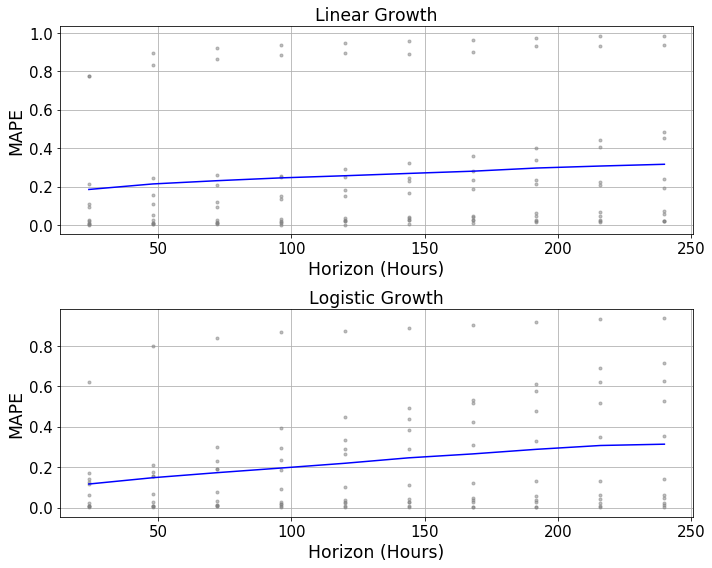

In [57]:
figcv, (ax1,ax2) = plt.subplots(2,1,figsize=(10,8))

#linear
plot_cross_validation_metric(cvresult_simp, metric='mape',ax=ax1);
ax1.set_title('Linear Growth',fontsize='xx-large' )
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_xlabel('Horizon (Hours)',fontsize='xx-large')
ax1.set_ylabel('MAPE',fontsize='xx-large')

#logistic
plot_cross_validation_metric(cvresult_simlog2, metric='mape',ax=ax2);
ax2.set_title('Logistic Growth',fontsize='xx-large')
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.set_xlabel('Horizon (Hours)',fontsize='xx-large')
ax2.set_ylabel('MAPE',fontsize='xx-large')

figcv.tight_layout();

**Figure.** Horizon is the number of days in the future we care about forecasting. Dots show the absolute percent error for each prediction in confirmed cases. The blue line shows the MAPE (Mean Absolute Percentage Error), where the mean is taken over a rolling window of the dots. 
We see for the linear model forecast that errors are around 32% for 1 day into the future and then increas up to around 50% for predictions that are 10 days out. For the logistic model forecast, errors are around 19% for 1 day into the future and then increas up to around 44% for predictions that are 10 days out.

### Plot linear vs logistic models.

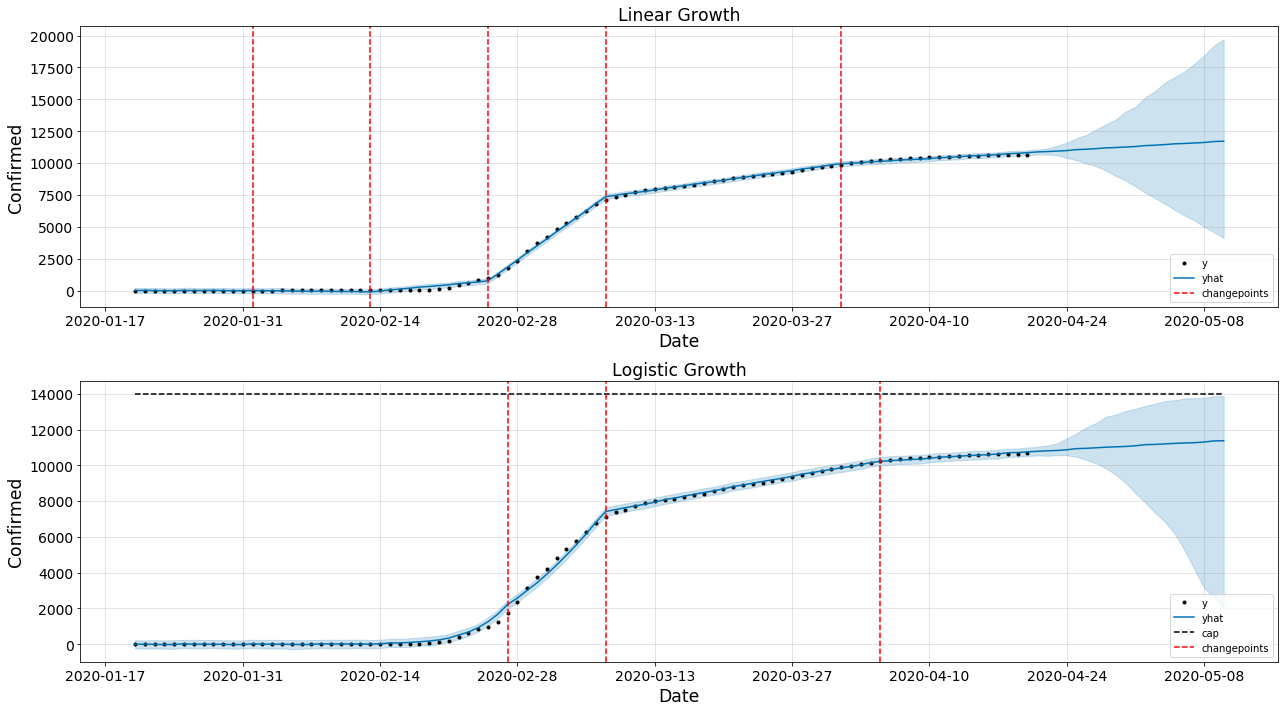

In [42]:
figvs, (ax1,ax2) = plt.subplots(2,1,figsize=(18,10))

#linear
future = simp.make_future_dataframe(periods=20)
forecast = simp.predict(future)
fig1 =simp.plot(forecast,ax = ax1);
ax1.set_title('Linear Growth',fontsize='xx-large' )
ax1.set_xlabel('Date',fontsize='xx-large')
ax1.set_ylabel('Confirmed',fontsize='xx-large')
ax1.tick_params(axis='both', which='major', labelsize=14)
#ax1.set_xticklabels(ax1.get_xticklabels(), rotation=60)

a1=add_changepoints_to_plot(ax=ax1,m=simp, fcst=forecast,trend = False)
a1[0].set_label('changepoints')
ax1.legend(loc=4)

#logistic
future = simlog2.make_future_dataframe(periods=20)
future['cap'] = 14000
forecast = simlog2.predict(future)
figvs2=simlog2.plot(forecast,ax=ax2)
ax2.set_xlabel('Date',fontsize='xx-large')
ax2.set_ylabel('Confirmed',fontsize='xx-large')
ax2.set_title('Logistic Growth',fontsize='xx-large')
a2 = add_changepoints_to_plot(ax=ax2, m=simlog2, fcst=forecast,trend = False)

ax2.tick_params(axis='both', which='major', labelsize=14)

#ax2.set_xticklabels(ax2.get_xticklabels(), rotation=60)
a2[0].set_label('changepoints')
ax2.legend(loc=4)

figvs.tight_layout()


#### Define changepoints

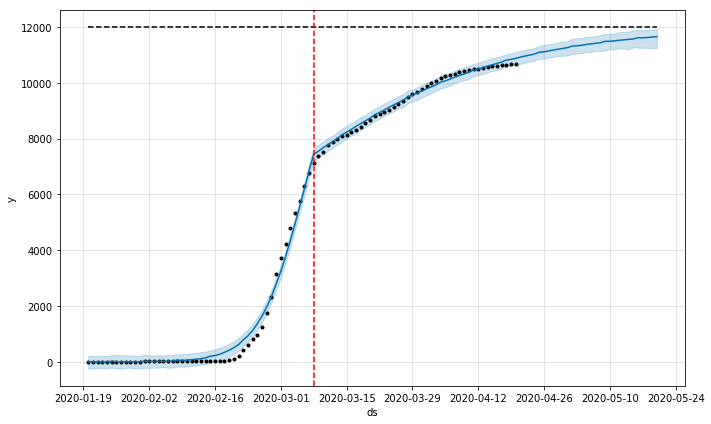

In [59]:
#define changepoints
simlog2 = Prophet(growth='logistic',
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
    changepoints = ['2020-03-08'],  #'2020-02-21', '2020-02-27',
    changepoint_prior_scale=0.5)
confirmed_data['cap'] = 12000
simlog2.fit(confirmed_data)
future = simlog2.make_future_dataframe(periods=30)
future['cap'] = 12000
forecast = simlog2.predict(future)
fig5 = simlog2.plot(forecast)

a5 = add_changepoints_to_plot(fig5.gca(), simlog2, forecast,trend=False)

In [338]:
cvresult_simlog1 = cross_validation(simlog2, horizon = '10 days')

print('Mean absolute percentage error is  {:.4f}.'.format(mape(cvresult_simlog2.yhat, 
                                                           cvresult_simlog2.y)))
performance_metrics(cvresult_simlog2)

INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-02-19 00:00:00 and 2020-03-20 00:00:00


Mean absolute percentage error is  0.3020.


,horizon,mse,rmse,mae,mape,coverage
0,1 days,2.005167e+05,447.790865,345.704342,0.396255,0.285714
1,2 days,4.062043e+05,637.341565,509.591484,0.231309,0.285714
2,3 days,7.028082e+05,838.336589,664.012340,0.190300,0.285714
3,4 days,1.193016e+06,1092.252599,872.434556,0.244945,0.285714
4,5 days,1.839014e+06,1356.102339,1101.149859,0.278177,0.285714
5,6 days,2.550177e+06,1596.927347,1285.552255,0.302766,0.285714
6,7 days,3.448705e+06,1857.068878,1491.147811,0.330851,0.285714
7,8 days,4.210825e+06,2052.029370,1673.442967,0.343557,0.285714
8,9 days,4.902112e+06,2214.071445,1824.000545,0.348355,0.285714
9,10 days,5.788328e+06,2405.894508,2003.393605,0.353576,0.285714


In [143]:
cvresult_simlog2 = cross_validation(simlog2, horizon = '10 days')

INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-02-19 00:00:00 and 2020-03-20 00:00:00


In [144]:
print('Mean absolute percentage error is  {:.4f}.'.format(mape(cvresult_simlog2.yhat, 
                                                           cvresult_simlog2.y)))

Mean absolute percentage error is  0.3020.


### MCMC optimization

This parameter determines if the model uses Maximum a posteriori (MAP) estimation or a full Bayesian inference with the specified number of Markov Chain Monte Carlo (MCMC) samples to train and predict.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/jinbiao.ji/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



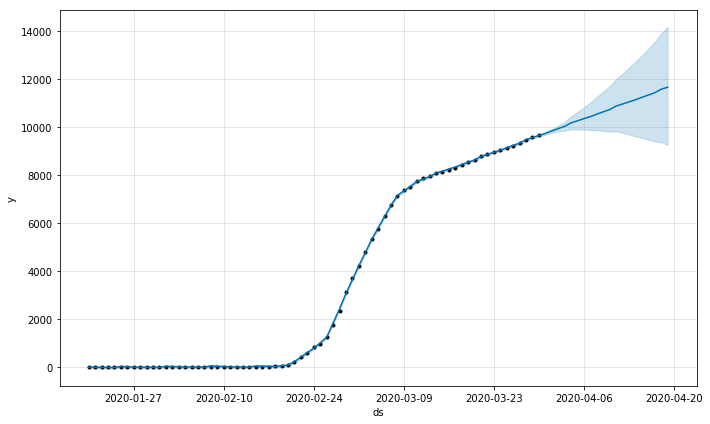

In [21]:
regmcmc = Prophet(mcmc_samples=5000)

#regmcmc.add_country_holidays(country_name='KR')

#confirmed_data['cap'] = 11000
regmcmc.fit(confirmed_data)
future = regmcmc.make_future_dataframe(periods=20)
#future['cap'] = 11000
forecast = regmcmc.predict(future)
fig7 = regmcmc.plot(forecast)

/Users/jinbiao.ji/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



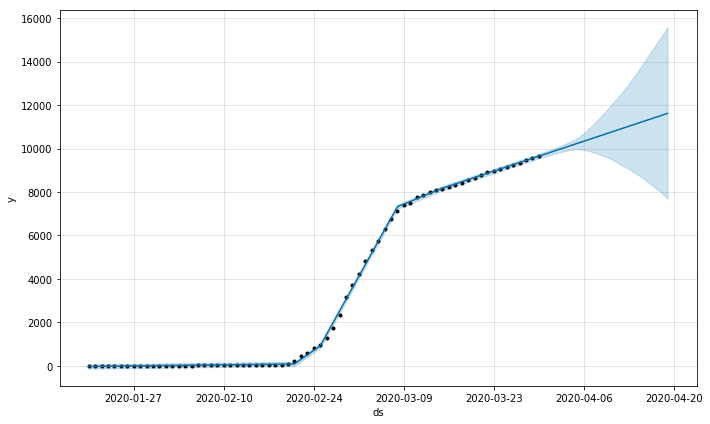

In [24]:
regmcmc2 = Prophet( yearly_seasonality=False,
    weekly_seasonality = False,
    daily_seasonality = True,
    seasonality_mode = 'additive',
    changepoints = ['2020-02-21', '2020-02-25','2020-03-08','2020-03-15'],
    changepoint_prior_scale=0.5,
                   mcmc_samples=5000)

#regmcmc.add_country_holidays(country_name='KR')

#confirmed_data['cap'] = 11000
regmcmc2.fit(confirmed_data)
future = regmcmc2.make_future_dataframe(periods=20)
#future['cap'] = 11000
forecast = regmcmc2.predict(future)
fig8 = regmcmc2.plot(forecast)

In [53]:
cvresult_regmcmc = diagnostics.cross_validation(regmcmc, horizon = '10 days')


INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-02-19 00:00:00 and 2020-03-20 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.
/Users/jinbiao.ji/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

/Users/jinbiao.ji/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

/Users/jinbiao.ji/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

/Users/jinbiao.ji/anaconda3/lib/python3.7/site-package

In [127]:
cvresult_regmcmc.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
65,2020-03-26,11599.675486,10608.485318,12550.321210,9241,2020-03-20
66,2020-03-27,11907.558972,10915.013556,12911.091570,9332,2020-03-20
67,2020-03-28,12395.158733,11374.112722,13411.752065,9478,2020-03-20
68,2020-03-29,12694.160522,11661.985074,13715.646528,9583,2020-03-20
69,2020-03-30,12988.444509,11913.713371,14041.460911,9661,2020-03-20


In [59]:
cvresult_regmcmc.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-02-20,38.395880,31.768425,45.026233,104,2020-02-19
1,2020-02-21,40.176921,33.553059,46.633744,204,2020-02-19
2,2020-02-22,40.427537,33.774595,47.107260,433,2020-02-19
3,2020-02-23,42.464411,35.672569,49.366382,602,2020-02-19
4,2020-02-24,43.891219,36.921213,50.631146,833,2020-02-19


In [128]:
performance_metrics(regmcmc)

AttributeError: 'Prophet' object has no attribute 'copy'

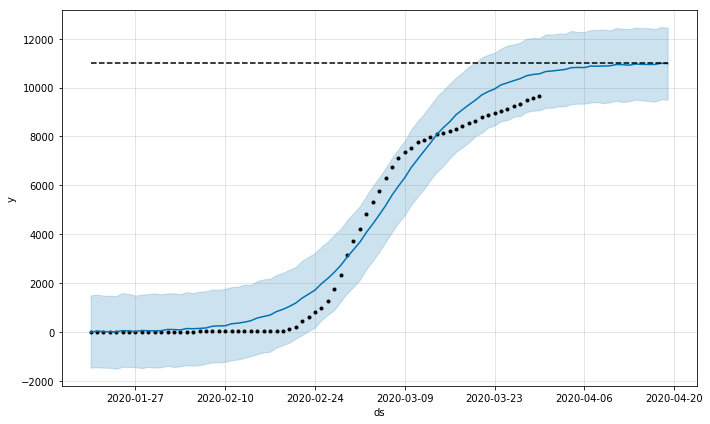

In [343]:
regmcmc3 = Prophet(growth='logistic',interval_width=0.95,
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
    changepoint_prior_scale=0.05,
    mcmc_samples=5000)

#regmcmc.add_country_holidays(country_name='KR')

confirmed_data['cap'] = 11000
regmcmc3.fit(confirmed_data)
future = regmcmc3.make_future_dataframe(periods=20)
future['cap'] = 11000
forecast = regmcmc3.predict(future)
fig9 = regmcmc3.plot(forecast)

In [341]:
#cvresult_regmcmc3 = diagnostics.cross_validation(regmcmc3, horizon = '10 days')

### Logistics Growth - Define funcion with the coefficients to estimate the 'cap'.

In [76]:
def func_logistic(t, a, b, c):
    return c / (1 + a * np.exp(-b*t))

In [77]:
from scipy.optimize import curve_fit

In [73]:
time.head()

,date,time,test,negative,confirmed,released,deceased
0,2020-01-20,16,1,0,1,0,0
1,2020-01-21,16,1,0,1,0,0
2,2020-01-22,16,4,3,1,0,0
3,2020-01-23,16,22,21,1,0,0
4,2020-01-24,16,27,25,2,0,0


a =  105424.2983481868
b =  0.2639761572797876
c =  8894.300142232034


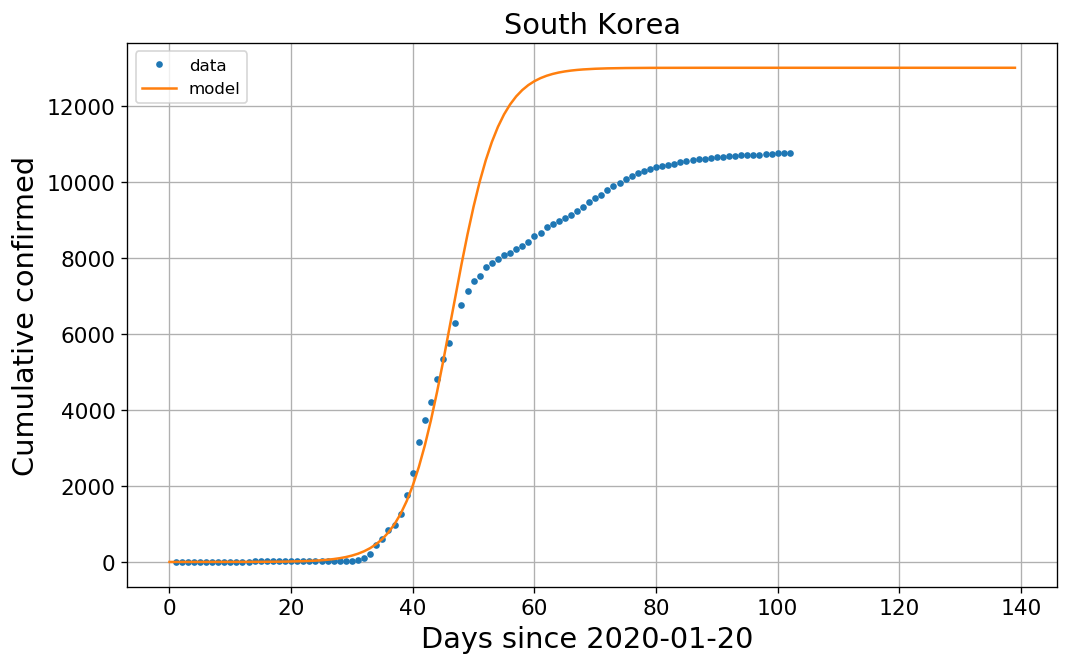

In [319]:
# Randomly initialize the coefficients
p0 = np.random.exponential(size=3)

# Set min bound 0 on all coefficients, and set different max bounds # for each coefficient
bounds = (0, [10000000., 1000., 1000000000.])

# Convert pd.Series to np.Array and use Scipy's curve fit to find   # the best Nonlinear Least Squares coefficients
x = np.array(time.index.values)+1
y = np.array(time['confirmed'])

(a,b,c),cov = curve_fit(func_logistic, 
                              x[:70], y[:70], bounds=bounds, p0=p0, maxfev=1000000)

print('a = ',a)
print('b = ',b)
print('c = ',c)

fig,ax=plt.subplots(figsize=(10,6),dpi = 120)

xx=np.arange(140)
ax.plot(x, y,'.',label = 'data')
ax.plot(xx, func_logistic(xx-3, a-10000, b, 13000),label = 'model')
ax.set_title('South Korea',fontsize='xx-large')
ax.set_xlabel('index')

ax.set_xlabel('Days since 2020-01-20 ',fontsize = 'xx-large')
ax.set_ylabel('Cumulative confirmed',fontsize = 'xx-large')
ax.tick_params(axis='both', which='major', labelsize=13)
#ax.set_xticks(time.date.values)
ax.grid()
ax.legend()

a =  539.324463581816
b =  0.09505752881460729
c =  254.1136404228165


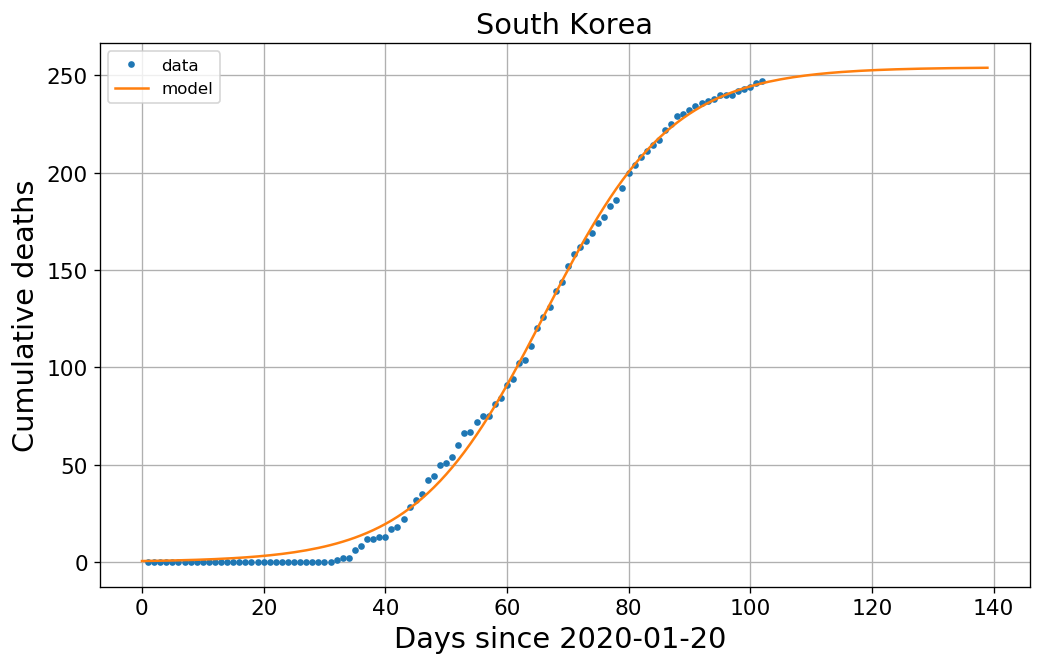

In [316]:
# Randomly initialize the coefficients
p0 = np.random.exponential(size=3)

# Set min bound 0 on all coefficients, and set different max bounds # for each coefficient
bounds = (0, [100000., 1000., 1000000000.])

# Convert pd.Series to np.Array and use Scipy's curve fit to find   # the best Nonlinear Least Squares coefficients
x = np.array(deaths[0:].index.values)+1
y = np.array(deaths[0:]['y'])

(a,b,c),cov = curve_fit(func_logistic, 
                              x, y, bounds=bounds, p0=p0, maxfev=1000000)

print('a = ',a)
print('b = ',b)
print('c = ',c)

fig,ax=plt.subplots(figsize=(10,6),dpi=120)

xx=np.arange(140)
ax.plot(x, y,'.',label='data')
ax.plot(xx, func_logistic(xx, a, b, c),label = 'model')
ax.set_title('South Korea',fontsize = 'xx-large')
ax.set_xlabel('Days since 2020-01-20 ',fontsize = 'xx-large')
ax.set_ylabel('Cumulative deaths',fontsize = 'xx-large')
ax.tick_params(axis='both', which='major', labelsize=13)
ax.grid()
ax.legend()

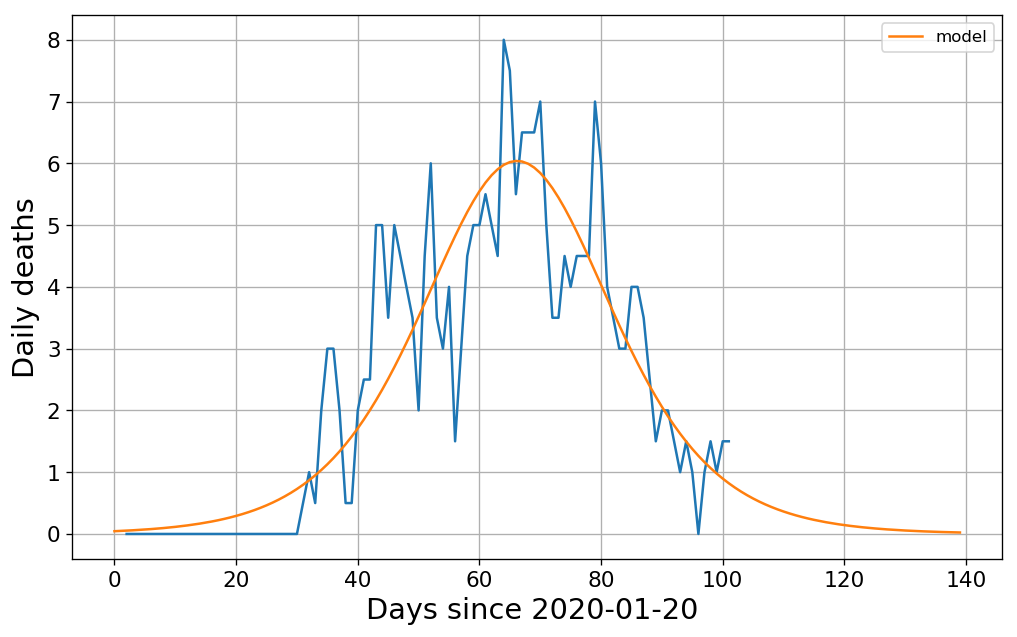

In [318]:
def d_logistic(x,a,b,c):
    h = 1e-5
    return (func_logistic(x+h,a,b,c)-func_logistic(x-h,a,b,c))/(2*h)

fig,ax=plt.subplots(figsize=(10,6),dpi=120)

ax.plot(x[1:-1],moving_average(np.diff(y),2))
ax.plot(xx,d_logistic(xx,a,b,c),label = 'model')


#ax.set_title('South Korea',fontsize = 'xx-large')
ax.set_xlabel('Days since 2020-01-20 ',fontsize = 'xx-large')
ax.set_ylabel('Daily deaths',fontsize = 'xx-large')
ax.tick_params(axis='both', which='major', labelsize=13)
ax.grid()
ax.legend()

In [79]:
# The time step at which the growth is fastest
t_fastest = np.log(a) / b
i_fastest = func_logistic(t_fastest, a, b, c)

In [80]:
res_df = time['date'].copy()
res_df['fastest_grow_day'] = t_fastest
res_df['fastest_grow_value'] = i_fastest
res_df['growth_stabilized'] = t_fastest <= x[-1]
res_df['timestep'] = x
res_df['res_func_logistic'] = func_logistic(x, a, b, c)


if t_fastest <= x[-1]:
    print('Growth stabilized: South Korea.','| Fastest grow day:', t_fastest, '| Infections:', i_fastest)
    res_df['cap'] = func_logistic(x[-1] + 10, a, b, c)
else:
    print('Growth increasing: South Korea,',  '| Fastest grow day:', t_fastest, '| Infections:', i_fastest)
    res_df['cap'] = func_logistic(i_fastest + 10, a, b, c)

Growth stabilized: South Korea. | Fastest grow day: 46.11124612183144 | Infections: 5112.626324191891


In [81]:
print('Estimated cap is ',res_df['cap'])

Estimated cap is  10225.153057780411
